In [1]:
from game_my import Game
from test import Test
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import random
from collections import namedtuple, deque
%matplotlib inline

c:\Users\kingp\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Transition = namedtuple('Transition',
  ('state', 'action', 'reward', 'next_state', 'done'))

class Memory:
  def __init__(self, max_size=10000):
    self.memory = deque([],maxlen=max_size)

  def push(self, *args):
    self.memory.append(Transition(*args))
  
  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [3]:
class PolicyNet(nn.Module):
  def __init__(self):
    super(PolicyNet, self).__init__()
    self.layers_stack = nn.Sequential(
        nn.Linear(16, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.Linear(16, 4),
        nn.Softmax()
    )

  def forward(self, x):
    y = self.layers_stack(x)
    return y

In [4]:
BATCH_SIZE = 10
TARGET_UPDATE = 10
GAMMA = .9999
EPS_START = 0.9
EPS_END = 0.03
EPS_DECAY = 300
LERNING_RATE = 25e-5
gStep = 0

memory = Memory(BATCH_SIZE*1000)
game = Game()

policy_net = PolicyNet()
target_net = PolicyNet()
for p in target_net.parameters():
  p.requires_grad = False

optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=LERNING_RATE)

def select_action(state):
  global gStep
  eps_thr = EPS_END + (EPS_START - EPS_END)*math.exp(-1*gStep/EPS_DECAY)
  if random.random() > eps_thr:
    return policy_net(state).argmax()
  return torch.tensor(random.randint(0,3), dtype=torch.long)
  
def optimize():
  if len(memory) < BATCH_SIZE:
    return torch.tensor([0.])
  transitions = memory.sample(BATCH_SIZE)
  batch = Transition(*zip(*transitions))
  
  b_mask = torch.tensor([i for i in range(len(batch.next_state)) if batch.next_state[i] is not None], dtype=torch.long)
  b_state = torch.stack(batch.state)[b_mask]
  b_reward = torch.tensor(batch.reward)[b_mask]
  b_action = torch.stack(batch.action)[b_mask]
  b_done = torch.tensor(batch.done, dtype=torch.float)[b_mask]

  b_next_state = torch.stack([i for i in batch.next_state if i is not None])
  
  # print(b_state.shape, b_reward.shape, b_action.shape, b_next_state.shape)

  optimizer.zero_grad()

  y = policy_net(b_state)
  y = y[torch.arange(y.size(0)), b_action]
  with torch.no_grad():
    tty = policy_net(b_next_state).argmax(1)
    # print(tty.shape)
    y_next = target_net(b_next_state)[torch.arange(0, b_next_state.size(0)), tty]
  # print(b_reward.shape, y_next.shape, y.shape)
    yt =  GAMMA*(y_next) + (1 - b_done)*b_reward
  # print(y.shape, yt.shape, y_next.shape)
  loss = F.smooth_l1_loss(y, yt)
  loss.backward()
  optimizer.step()
  return loss

In [5]:
EPOCHES = 802
MAX_MOVES = 850
# LERNING_RATE = 25e-7

# gStep = 0
gLoss = []
gScore = []
gMoves = []
gRewards = []

for ie in tqdm(range(EPOCHES)):
  moves = 0
  game.clear()
  state = game.get_field()
  score = 0
  lreward = 0
  while moves < MAX_MOVES:
    action = select_action(state)
    next_state, reward, done, score = game.step4(action)
    if done:
      next_state = None
    
    memory.push(state, action, reward, next_state, done)
    state = next_state

    closs = optimize()
    gLoss.append(closs.mean().item())
    lreward += reward
    if done:
      break
    moves += 1
  
  if not(ie % TARGET_UPDATE):
    target_net.load_state_dict(policy_net.state_dict())

  gRewards.append(lreward)
  gScore.append(score)
  gMoves.append(moves)

  0%|          | 0/802 [00:00<?, ?it/s]c:\Users\kingp\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
 43%|████▎     | 347/802 [01:10<01:31,  4.95it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'gRewards')

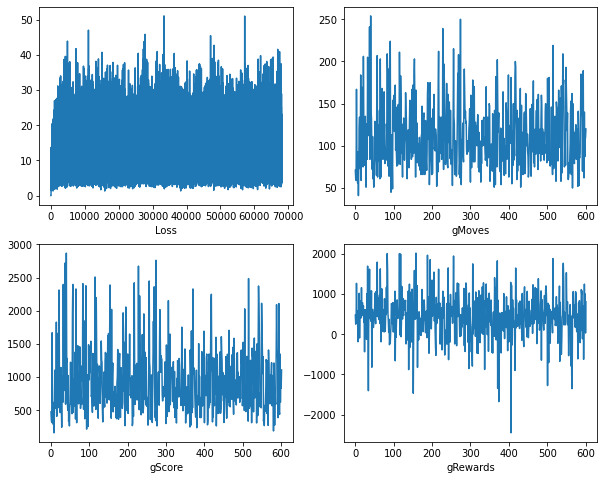

In [ ]:
# plt.figure(figsize=(20,16))
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10,8)
ax[0][0].plot(gLoss)
ax[0][0].set_xlabel('Loss')
ax[0][1].plot(gMoves)
ax[0][1].set_xlabel('gMoves')
ax[1][0].plot(gScore)
ax[1][0].set_xlabel('gScore')
ax[1][1].plot(gRewards)
ax[1][1].set_xlabel('gRewards')


In [ ]:
a = pd.DataFrame(gScore)
a.describe()

,0
count,102.000000
mean,921.254902
std,442.922421
min,92.000000
25%,585.000000
50%,896.000000
75%,1218.000000
max,2644.000000
